# DESCARGAR MLSERVER DESDE DOCKER


Descargar Docker y la imgen que vamos a usar

In [ ]:
sudo docker pull petkakotletka/object-detection-mlserver:latest

### Verificamos que lo tenemos en nuestro Docker

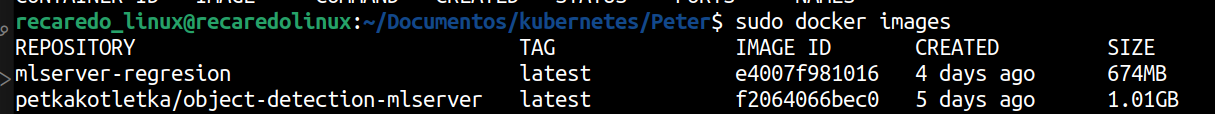

### Arrancamos un contenedor 


In [ ]:
docker run -p 8080:8080 -p 8081:8081 -p 8082:8082 petkakotletka/object-detection-mlserver:latest

### Verificamos que este running

In [ ]:
sudo docker ps

# Ejemplo de creacion de Imagen Docker para usar Yolo

## (custom_model.py) 
#### Archivo donde se especifica como usar el predict() en el endpoint

In [ ]:
import os
import numpy as np
from typing import Dict, List, Any
from mlserver import MLModel
from mlserver.types import InferenceRequest, InferenceResponse, ResponseOutput
from mlserver.errors import InferenceError
import json

# Import the detector class
from yolo_detector import YOLOObjectDetector


class ObjectDetectionModel(MLModel):
    async def load(self) -> bool:
        # Create the detector instance directly
        self.model = YOLOObjectDetector()

        # No need to load it now - will load on first prediction
        self.ready = True
        return self.ready

    async def predict(self, payload: InferenceRequest) -> InferenceResponse:
        try:
            # Extract images from payload
            inputs = payload.inputs[0]
            image_data = inputs.data

            # Get predictions
            predictions = self.model.predict(image_data)

            # Format response
            return InferenceResponse(
                model_name=self.name,
                model_version=self._settings.parameters.version,
                outputs=[
                    ResponseOutput(
                        name="detections",
                        shape=[len(predictions)],
                        datatype="BYTES",
                        data=[json.dumps(pred) for pred in predictions],
                    )
                ],
            )
        except Exception as e:
            raise InferenceError(f"Error during inference: {str(e)}")


## (model-settings.json)
#### uri -> especificamos la ruta del archivo que contiene el modelo 

In [ ]:
{
  "name": "object-detection",
  "implementation": "custom_model.ObjectDetectionModel",
  "parameters": {
    "uri": "model.joblib",
    "version": "v1.0.0"
  }
}

## (settings.json)

In [ ]:
{
  "host": "0.0.0.0",
  "http_port": 8080,
  "grpc_port": 8081,
  "metrics_port": 8082,
  "models_dir": "./models"
}

## (Dockerfile)

In [ ]:
FROM python:3.9-slim

WORKDIR /app

# Install required packages
RUN apt-get update && apt-get install -y libgl1-mesa-glx libglib2.0-0 wget

# Install Python dependencies
RUN pip install mlserver opencv-python-headless numpy Pillow

# Create directory structure
RUN mkdir -p models/object-detection

# Copy model files
COPY yolo_detector.py .
COPY custom_model.py .
COPY model-settings.json ./models/object-detection/
COPY settings.json .

# Download required model files
RUN wget -O yolov3-tiny.weights https://pjreddie.com/media/files/yolov3-tiny.weights && \
    wget -O yolov3-tiny.cfg https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3-tiny.cfg && \
    wget -O coco.names https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names && \
    mv yolov3-tiny.weights yolov3-tiny.cfg coco.names ./models/object-detection/

# Expose ports
EXPOSE 8080
EXPOSE 8081
EXPOSE 8082

# Start MLServer
CMD mlserver start .

# Modificacion archivo (single_image.py)


### Codigo que envia al endpoint una imagen y comprueba que funciona

In [ ]:
import requests
import json
import base64
from PIL import Image, ImageDraw
import io
import numpy as np
import matplotlib.pyplot as plt
import sys

# Function to load and encode image


def encode_image(image_path):
    with open(image_path, "rb") as img_file:
        img_bytes = img_file.read()

    base64_encoded = base64.b64encode(img_bytes).decode('utf-8')
    return f"data:image/jpeg;base64,{base64_encoded}"

# Function to visualize results


def visualize_results(image_path, detections):
    # Load image
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)

    # Draw bounding boxes
    for detection in detections:
        bbox = detection['bbox']
        label = f"{detection['class']} {detection['confidence']:.2f}"

        # Draw rectangle
        draw.rectangle(bbox, outline="red", width=3)

        # Draw label
        draw.text((bbox[0], bbox[1] - 10), label, fill="red")

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(np.array(img))
    plt.axis('off')
    plt.show()


def main():
    # Get image path from command line argument or use default
    image_path = sys.argv[1] if len(sys.argv) > 1 else "image.jpg"

    try:
        # Encode image
        encoded_image = encode_image(image_path)

        # Format for MLServer inference API
        inference_request = {
            "inputs": [
                {
                    "name": "images",
                    "shape": [1],
                    "datatype": "BYTES",
                    "data": [encoded_image]
                }
            ]
        }

        # Send the request
        url = "http://localhost:8080/v2/models/object-detection/infer"
        response = requests.post(url, json=inference_request)

        # Print status code
        print(f"Status code: {response.status_code}")

        if response.status_code == 200:
            # Parse response
            result = response.json()
            detections = json.loads(result["outputs"][0]["data"][0])

            # Print detected objects
            print(f"Detected {len(detections)} objects:")
            for i, det in enumerate(detections):
                print(f"  {i+1}. {det['class']} (confidence: {det['confidence']:.2f})")

            # Visualize results
            visualize_results(image_path, detections)
        else:
            print(f"Error: {response.text}")

    except Exception as e:
        print(f"Error: {str(e)}")


if __name__ == "__main__":
    main()

### Ejecutar en la terminar para comprobar que funciona 

In [ ]:
python test/single_image.py